In [105]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#from xgboost.sklearn import XGBClassifier

%matplotlib inline
plt.style.use('ggplot')

sns.set_style("white", {'ytick.major.size': 10.0})
sns.set_context("poster", font_scale=1.0)

In [106]:
np.random.seed(0)

In [107]:
#Loading data
train_users = pd.read_csv('../input/train_users_2.csv')
test_users = pd.read_csv('../input/test_users.csv')
sessions = pd.read_csv('../input/sessions.csv')
age_gender = pd.read_csv('../input/age_gender_bkts.csv')
countries = pd.read_csv('../input/countries.csv')

In [108]:
pd.isnull(train_users).sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

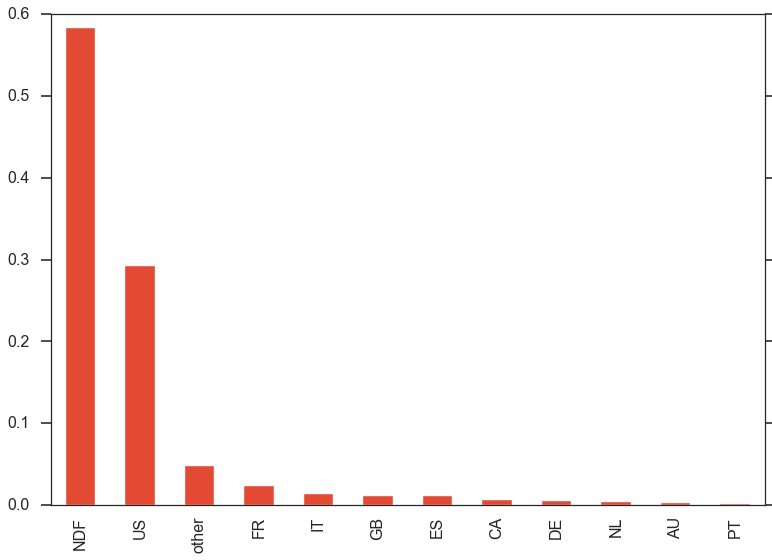

In [109]:
#Summary of labels
count_labels = train_users.country_destination.value_counts()
count_labels.div(count_labels.sum()).plot(kind='bar')

(0, 70)

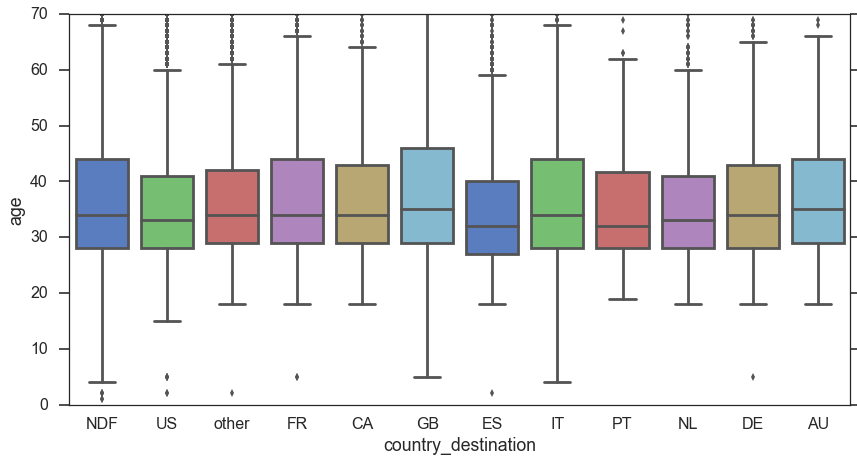

In [110]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(14, 7))
sns.boxplot(x='country_destination', y='age', data=train_users, palette="muted", ax=ax)
ax.set_ylim([0, 70])

In [111]:
labels = train_users['country_destination'].values
# df_train = df_train.drop(['country_destination'], axis=1)
id_test = test_users['id']
piv_train = train_users.shape[0]

In [112]:
#Creating a DataFrame with train+test data
users = pd.concat((train_users, test_users), axis=0, ignore_index=True)
#Removing id and date_first_booking
users = users.drop(['id', 'date_first_booking'], axis=1)
#Filling nan
#df_all = df_all.fillna(-1)

## Feature Engineering

In [113]:
#Gender
users.gender.replace('-unknown-', np.nan, inplace=True)
users.gender.value_counts()

FEMALE    77524
MALE      68209
OTHER       334
Name: gender, dtype: int64

In [114]:
users_nan = (users.isnull().sum() / users.shape[0]) * 100
users_nan[users_nan > 0].drop('country_destination')

age                        42.412365
first_affiliate_tracked     2.208335
gender                     46.990169
dtype: float64

In [115]:
#date_account_created
dac = np.vstack(users.date_account_created.astype(str).apply(lambda x: list(map(int, x.split('-')))).values)
users['dac_year'] = dac[:,0]
users['dac_month'] = dac[:,1]
users['dac_day'] = dac[:,2]
users['dac_yymmdd'] = pd.to_datetime(users.date_account_created, format="%Y-%m-%d")
users['dac_weekday'] = users['dac_yymmdd'].dt.dayofweek
users = users.drop(['date_account_created'], axis=1)

In [116]:
#timestamp_first_active
   
tfa = np.vstack(users.timestamp_first_active.astype(str).apply(lambda x: list(map(int, [x[:4],
                                                                                         x[4:6],
                                                                                         x[6:8],
                                                                                         x[8:10],
                                                                                         x[10:12],
                                                                                         x[12:14]]))).values)
users['tfa_year'] = tfa[:,0]
users['tfa_month'] = tfa[:,1]
users['tfa_day'] = tfa[:,2]
users['tfa_yymmdd'] = pd.to_datetime((users.timestamp_first_active // 1000000), format='%Y%m%d')
users['tfa_weekday'] = users['dac_yymmdd'].dt.dayofweek
users = users.drop(['timestamp_first_active'], axis=1)

In [117]:
#Time diff between dac and tfa in days
users['dac_tfa'] = (users.dac_yymmdd - users.tfa_yymmdd).astype('timedelta64[D]')

In [118]:
#Age
print(users[users.age > 122]['age'].describe(), '\n')
print(users[users.age < 18]['age'].describe(), '\n')
print(users[(users.age > 1900) & (users.age < 2000)]['age'].describe())

count     830.000000
mean     2002.620482
std        94.201344
min       132.000000
25%      2014.000000
50%      2014.000000
75%      2014.000000
max      2014.000000
Name: age, dtype: float64 

count    188.000000
mean      12.718085
std        5.764569
min        1.000000
25%        5.000000
50%       16.000000
75%       17.000000
max       17.000000
Name: age, dtype: float64 

count      71.000000
mean     1935.647887
std        12.179724
min      1920.000000
25%      1927.000000
50%      1933.000000
75%      1941.500000
max      1995.000000
Name: age, dtype: float64


In [119]:
# assume that any values between 1920 and 1995 are birth years
av = users.age.values
users['age'] = np.where(np.logical_and(av < 1996, av > 1919), 2015 - av, av)
users['age'] = np.where(np.logical_or(av < 13, av > 95), np.nan, av)

In [27]:
# #Categorical
# categorical_feats = [
#     'affiliate_channel',
#     'affiliate_provider',
#     'country_destination',
#     'first_affiliate_tracked',
#     'first_browser',
#     'first_device_type',
#     'gender',
#     'language',
#     'signup_app',
#     'signup_method'
# ]

# for categorical_feat in categorical_feats:
#     users[categorical_feat] = users[categorical_feat].astype('category')

## Further EDA

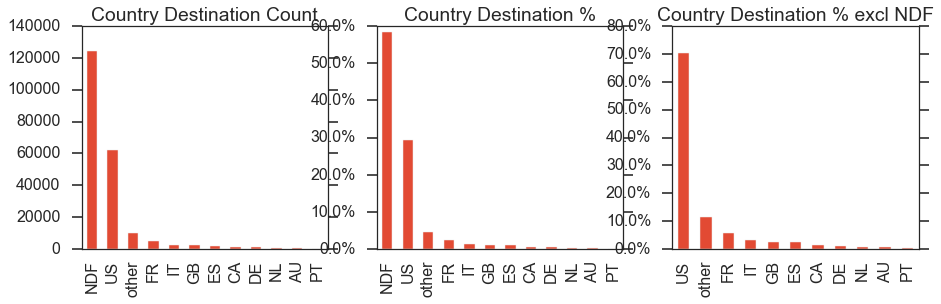

In [299]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(15, 4))
country_counts = df_train.country_destination.value_counts()
country_counts.plot(kind='bar',title='Country Destination Count',ax=axes[0])
ax = country_counts.div(country_counts.sum()).plot(kind='bar',title='Country Destination %',ax=axes[1] )
ax.set_yticklabels(['{:3.1f}%'.format(x*100) for x in ax.get_yticks()]);
booked_count = df_train[df_train.country_destination != 'NDF'].country_destination.value_counts()
ax1 = booked_count.div(booked_count.sum()).plot(kind='bar',title='Country Destination % excl NDF',ax=axes[2] )
ax1.set_yticklabels(['{:3.1f}%'.format(x*100) for x in ax1.get_yticks()]);

* All 12 classes are represented in the training data and we can see that nearly 60% of users do not make a booking. 
* Of the 40% of all users that do book, about 70% do so in the US. 
* We have rather imbalanced classes and will need to keep this in mind when training our model.

### Gender

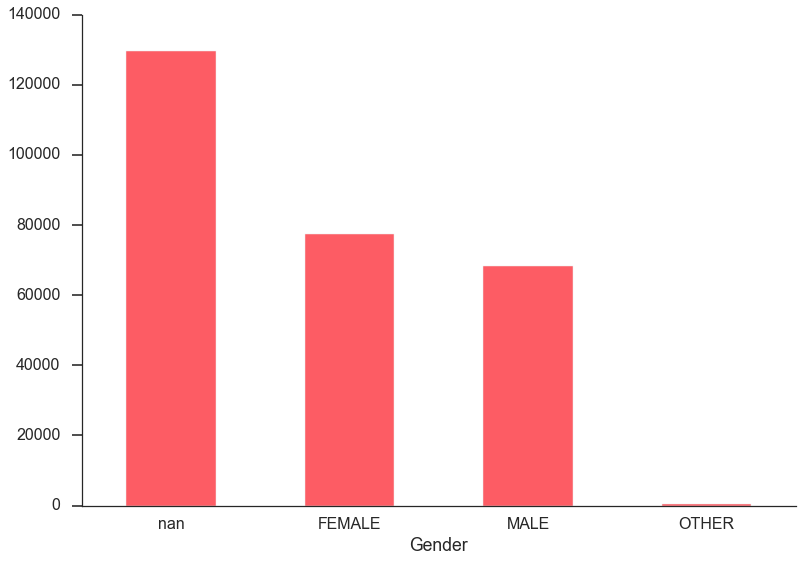

In [163]:
users.gender.value_counts(dropna=False).plot(kind='bar', color='#FD5C64', rot=0)
plt.xlabel('Gender')
sns.despine()

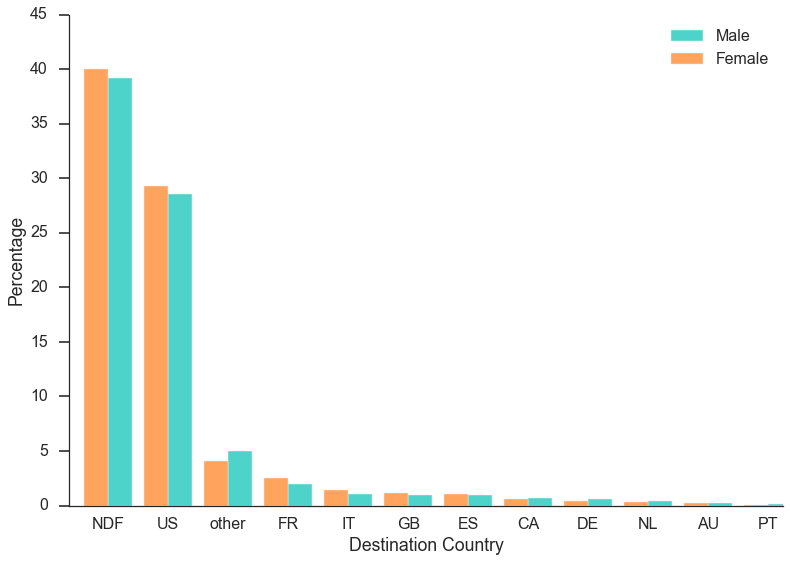

In [164]:
women = sum(users['gender'] == 'FEMALE')
men = sum(users['gender'] == 'MALE')

female_destinations = users.loc[users['gender'] == 'FEMALE', 'country_destination'].value_counts() / women * 100
male_destinations = users.loc[users['gender'] == 'MALE', 'country_destination'].value_counts() / men * 100

# Bar width
width = 0.4

male_destinations.plot(kind='bar', width=width, color='#4DD3C9', position=0, label='Male', rot=0)
female_destinations.plot(kind='bar', width=width, color='#FFA35D', position=1, label='Female', rot=0)

plt.legend()
plt.xlabel('Destination Country')
plt.ylabel('Percentage')

sns.despine()
plt.show()

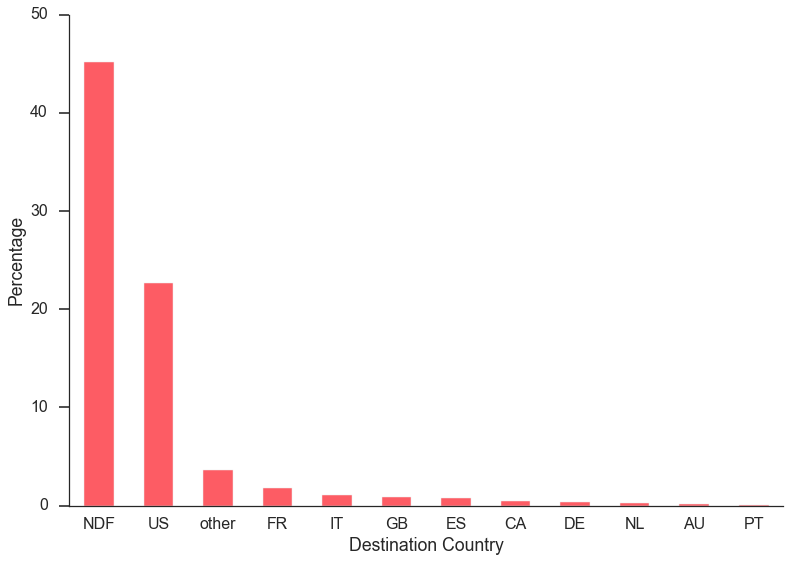

In [165]:
destination_percentage = users.country_destination.value_counts() / users.shape[0] * 100
destination_percentage.plot(kind='bar',color='#FD5C64', rot=0)
# Using seaborn can also be plotted
# sns.countplot(x="country_destination", data=users, order=list(users.country_destination.value_counts().keys()))
plt.xlabel('Destination Country')
plt.ylabel('Percentage')
sns.despine()

### Age

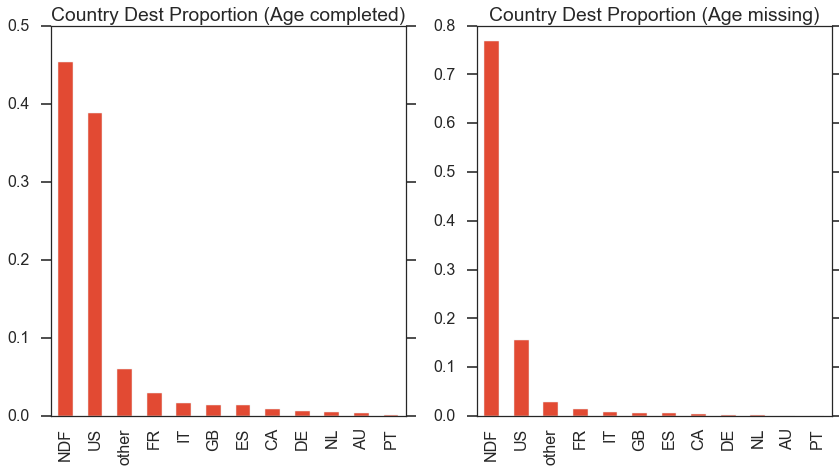

In [297]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(14, 7))
complete_age = df_train[df_train.age.notnull()].country_destination.value_counts()
missing_age = df_train[df_train.age.isnull()].country_destination.value_counts()
complete_age.div(complete_age.sum()).plot(kind='bar',title='Country Dest Proportion (Age completed)',ax=axes[0])
missing_age.div(missing_age.sum()).plot(kind='bar',title='Country Dest Proportion (Age missing)',ax=axes[1])

The age data also has a significant number of missing values. The plots above show the country destination proportions for users who have provided their age and for those where age is missing. Only 25% of users with missing ages book while 55% of users with age provided book. This suggests there is value to identifying users who have not provided age if, for example, we decide to impute missing ages. It could be that taking the step of providing age is a sign a user is more serious about making a booking.

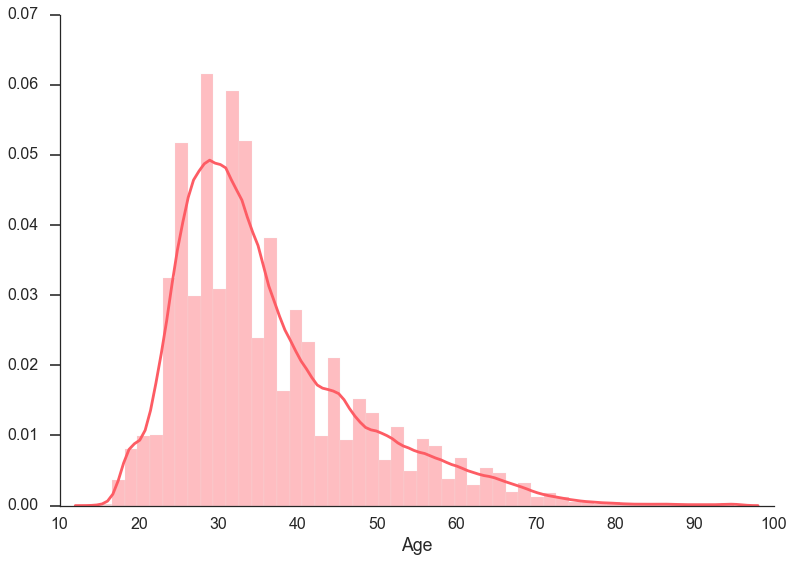

In [255]:
sns.distplot(users.age.dropna(), color='#FD5C64')
plt.xlabel('Age')
sns.despine()

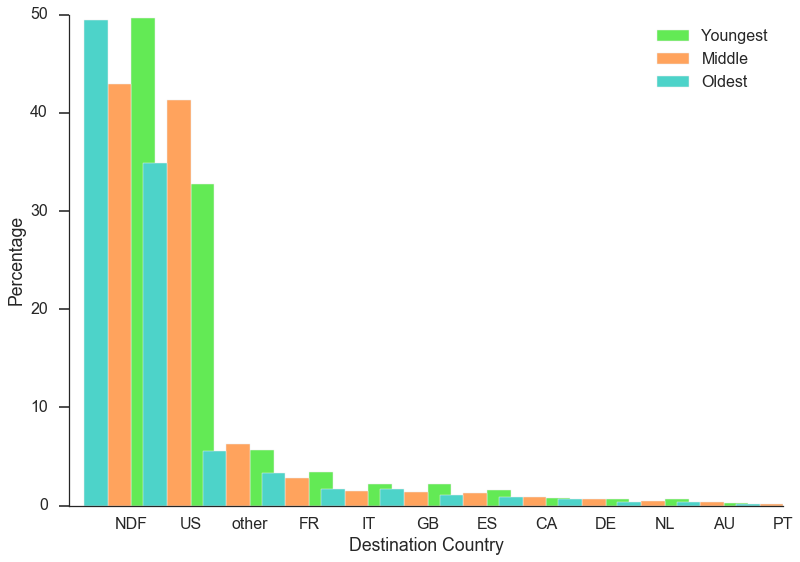

In [293]:
age1 = 25
age2= 40

cond_youngest = users.loc[users['age'] < age1, 'country_destination']
cond_middle = users.loc[(users['age'] >= age1) & (users['age'] <= age2), 'country_destination']
cond_oldest = users.loc[users['age'] > age2, 'country_destination']
                         
youngest = sum(cond_youngest.value_counts())
middle = sum(cond_middle.value_counts())
oldest = sum(cond_oldest.value_counts())

youngest_destinations = cond_youngest.value_counts() / youngest * 100
middle_destinations = cond_middle.value_counts() / middle * 100
oldest_destinations = cond_oldest.value_counts() / oldest * 100

youngest_destinations.plot(kind='bar', width=width, color='#63EA55', position=0, label='Youngest', rot=0)
middle_destinations.plot(kind='bar', width=width, color='#FFA35D', position=1, label='Middle', rot=0)
oldest_destinations.plot(kind='bar', width=width, color='#4DD3C9', position=2, label='Oldest', rot=0)

plt.legend()
plt.xlabel('Destination Country')
plt.ylabel('Percentage')

sns.despine()
plt.show()

In [289]:
def mapAgeGroup(age):
    if age < 25:
        return 'A'
    elif age <= 40:
        return 'B'
    else:
        return 'C'

In [290]:
users['age_group'] = users.age.map(mapAgeGroup)
by_age_group = \
    users.groupby(['age_group', 'country_destination'])['language'].agg({'count':lambda x: x.count()})
age_group_pcts = by_age_group.groupby(level=0).apply(lambda x: 100*x/float(x.sum())).reset_index()

In [291]:
age_group_pcts.head(10)

,age_group,country_destination,count
0,A,AU,0.231932
1,A,CA,0.677243
2,A,DE,0.760738
3,A,ES,2.207997
4,A,FR,3.376937
5,A,GB,1.604973
6,A,IT,2.207997
7,A,NDF,49.642824
8,A,NL,0.714352
9,A,PT,0.148437


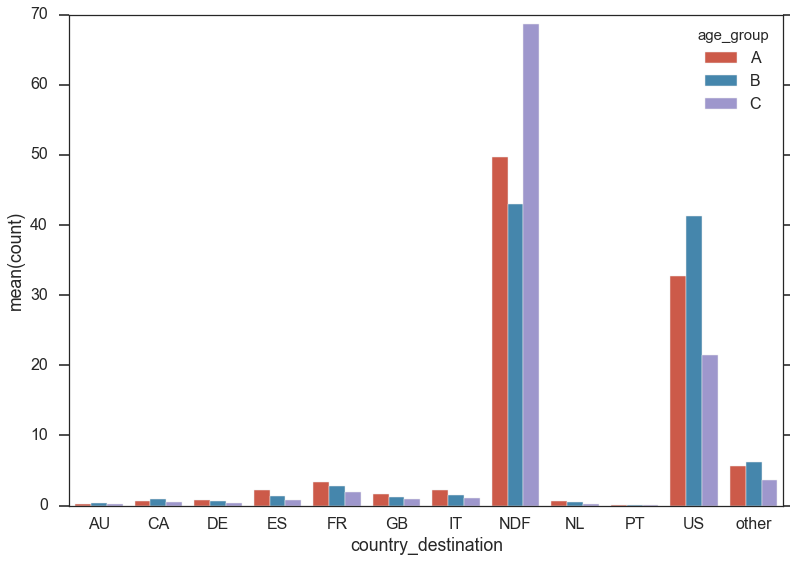

In [292]:
ax = sns.barplot(x="country_destination", y="count", hue="age_group", data=age_group_pcts)

Very young and old exhibit similar behaviours, those who travel the most between yrs 25-40 is a group

### Dates

In [166]:
users.columns

Index([u'affiliate_channel', u'affiliate_provider', u'age',
       u'country_destination', u'first_affiliate_tracked', u'first_browser',
       u'first_device_type', u'gender', u'language', u'signup_app',
       u'signup_flow', u'signup_method', u'dac_year', u'dac_month', u'dac_day',
       u'dac_yymmdd', u'dac_weekday', u'tfa_year', u'tfa_month', u'tfa_day',
       u'tfa_yymmdd', u'tfa_weekday', u'dac_tfa'],
      dtype='object')

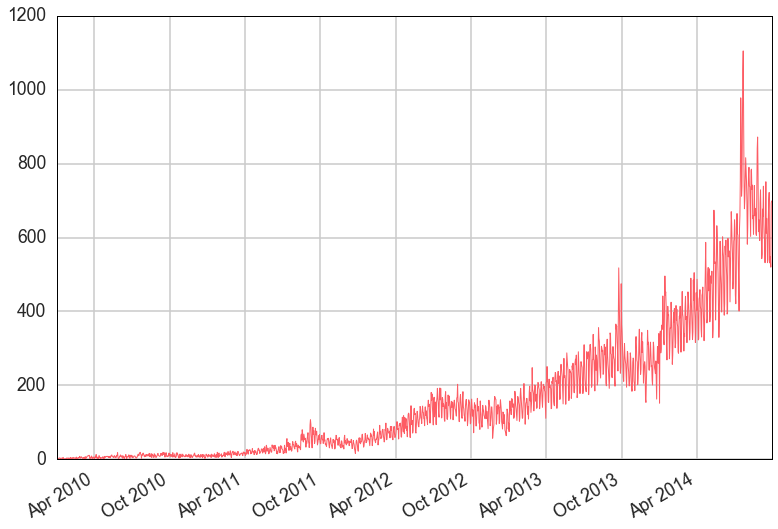

In [167]:
sns.set_style("whitegrid", {'axes.edgecolor': '0'})
sns.set_context("poster", font_scale=1.1)
users.dac_yymmdd.value_counts().plot(kind='line', linewidth=1.0, color='#FD5C64')

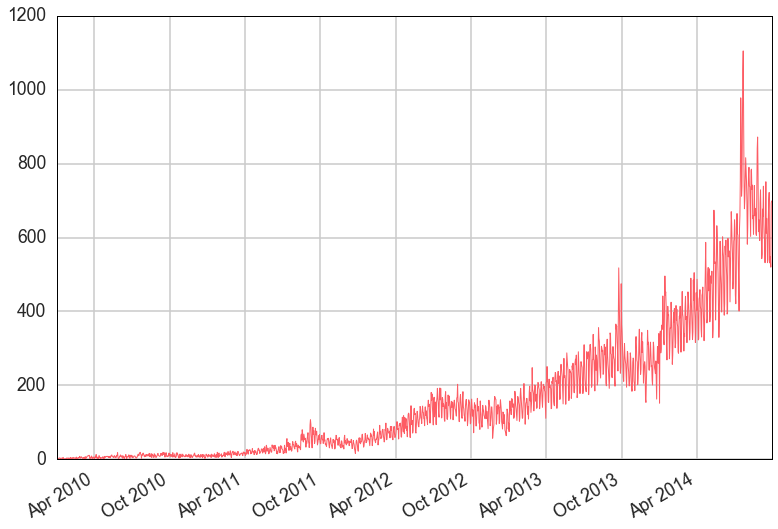

In [168]:
users.dac_yymmdd.value_counts().plot(kind='line', linewidth=1.0, color='#FD5C64')

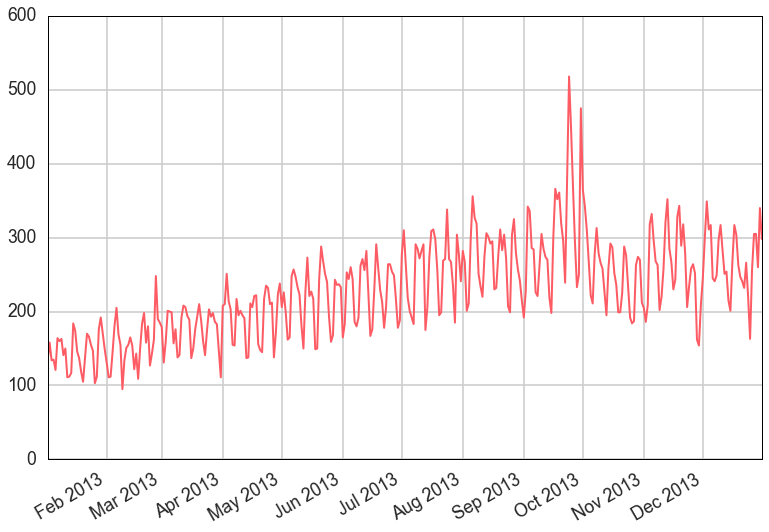

In [172]:
users_2013 = users[users['dac_yymmdd'] > pd.to_datetime(20130101, format='%Y%m%d')]
users_2013 = users_2013[users_2013['dac_yymmdd'] < pd.to_datetime(20140101, format='%Y%m%d')]
users_2013.dac_yymmdd.value_counts().plot(kind='line', linewidth=2, color='#FD5C64')
plt.show()

Looks like approximately 4 peaks and troughs in a month roughly with the same distance between them

In [173]:
weekdays = []
for date in users.dac_yymmdd:
    weekdays.append(date.weekday())
weekdays = pd.Series(weekdays)

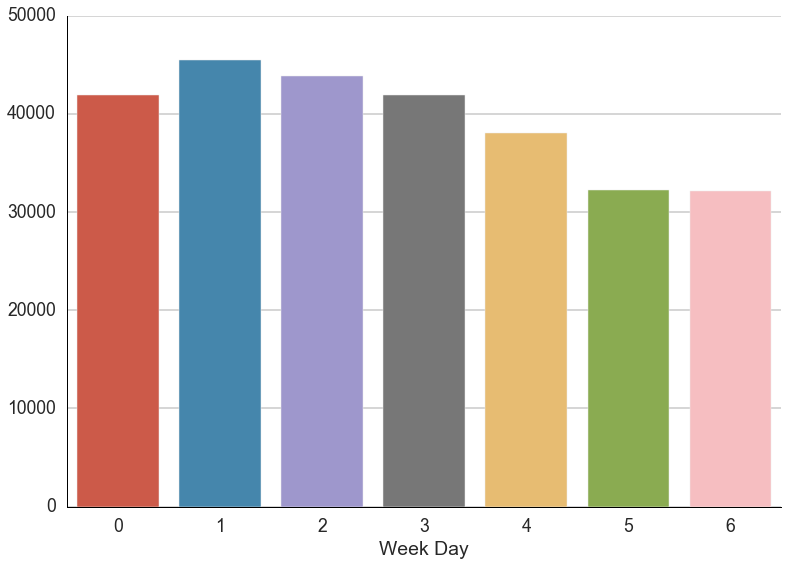

In [174]:
sns.barplot(x = weekdays.value_counts().index, y=weekdays.value_counts().values, order=range(0,7))
plt.xlabel('Week Day')
sns.despine()

In [177]:
by_dac_yymmdd = users.groupby(['dac_yymmdd', 'dac_weekday'])['language'].agg({'count': lambda x:x.count()}).reset_index()
by_dac_yymmdd.head()

,dac_yymmdd,dac_weekday,count
0,2010-01-01,4,1
1,2010-01-02,5,1
2,2010-01-03,6,1
3,2010-01-04,0,3
4,2010-01-05,1,3


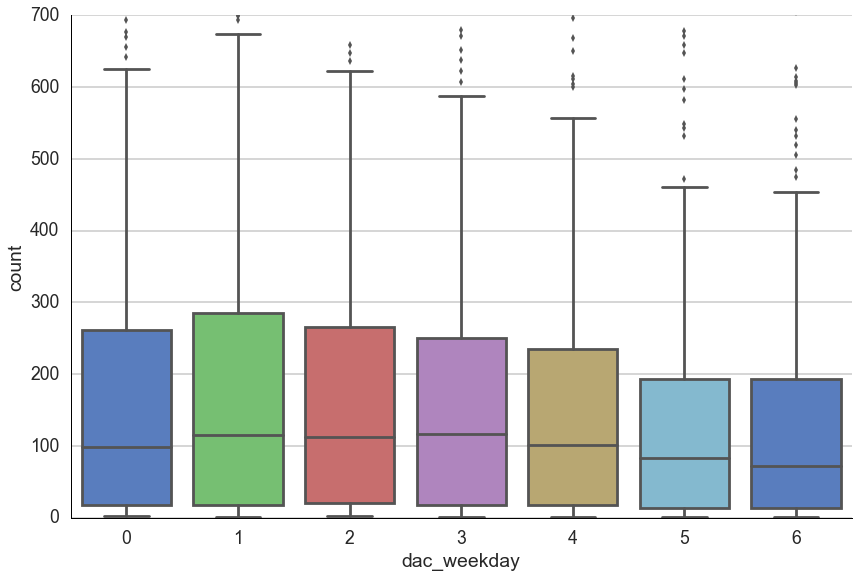

In [188]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(14, 9))
sns.boxplot(x='dac_weekday', y='count', data=by_dac_yymmdd, palette="muted", ax=ax)
ax.set_ylim([0, 700])
sns.despine()

The local minimums where the Sundays(where the people use less the Internet), and it's usually to hit a maximum at Tuesdays!

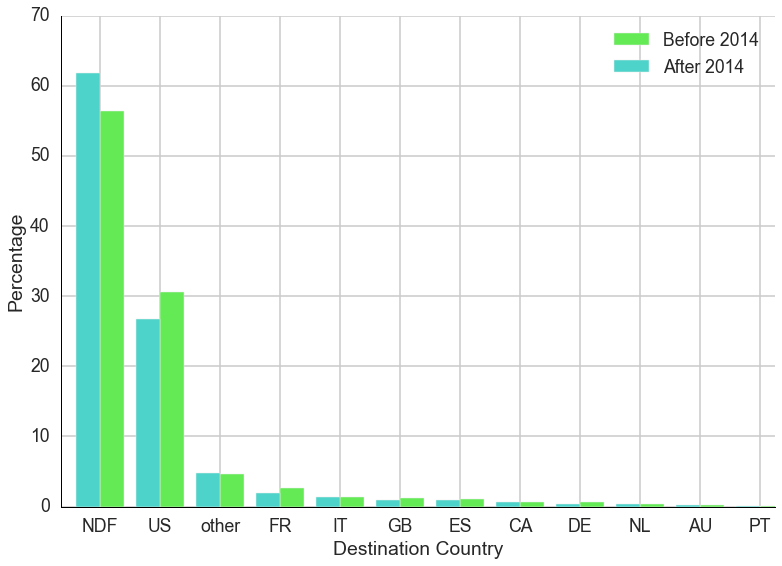

In [191]:
date = pd.to_datetime(20140101, format='%Y%m%d')

before = sum(users.loc[users['dac_yymmdd'] < date, 'country_destination'].value_counts())
after = sum(users.loc[users['dac_yymmdd'] > date, 'country_destination'].value_counts())
before_destinations = users.loc[users['dac_yymmdd'] < date, 
                                'country_destination'].value_counts() / before * 100
after_destinations = users.loc[users['dac_yymmdd'] > date, 
                               'country_destination'].value_counts() / after * 100
before_destinations.plot(kind='bar', width=width, color='#63EA55', position=0, label='Before 2014', rot=0)
after_destinations.plot(kind='bar', width=width, color='#4DD3C9', position=1, label='After 2014', rot=0)

plt.legend()
plt.xlabel('Destination Country')
plt.ylabel('Percentage')

sns.despine()
plt.show()

It's a clean comparision of usual destinations then and now, where we can see how the new users:
* Register more and book less.
* And when they book they stay at the US.

In [ ]:
#Categorical

There are a lot of categorical variable so this chart is a bit crowded. Below are some quick comments about each.
* Starting with gender, it appears users with 'unknown' gender book less frequently than those with a known one while users with gender 'other' book more frequently
* Users with the 'google' signup_method book less frequently than 'basic' or 'facebook'
* Users with signup_flow 3 book more frequently than any other category while several have nearly 100% 'NDF'
* Users with affiliate_channel 'content' book less frequently than other categories
* Users with affiliate_provider 'craigslist', direct', and 'google' book more frequently than other categories (this begs the question as to why the google affiliate channel is more effective than the google sign up method)
* Users with first_affiliate_tracked 'local ops' book less frequently than other categories
* Users with signup_app 'Web' booked the most frequently, while those with 'Android' booked the least
* Users with first_device_type 'Mac_Desktop' booked the most frequently, while those with 'Android Phone' booked the least
* The chart on first_browser highlights the large number used above all else; it is difficult to glean any meaningful insights beyond that some obscure browsers that are not likely widely used have very high or very low booking frequencies.
* The chart on language is somewhat surprising given that all the users were from the US - there are a large number of languages represented and this may warrant further investigation

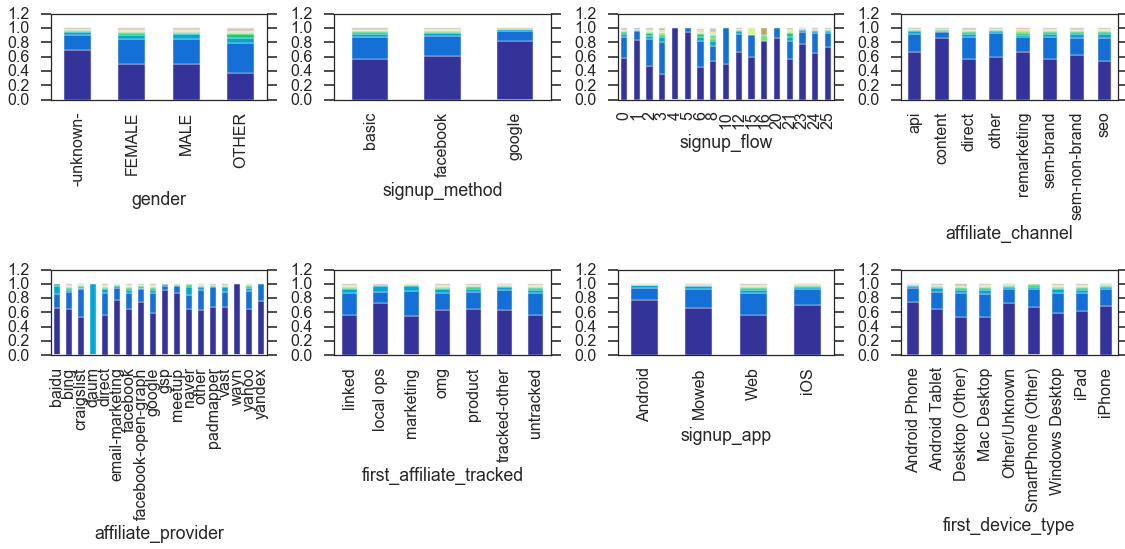

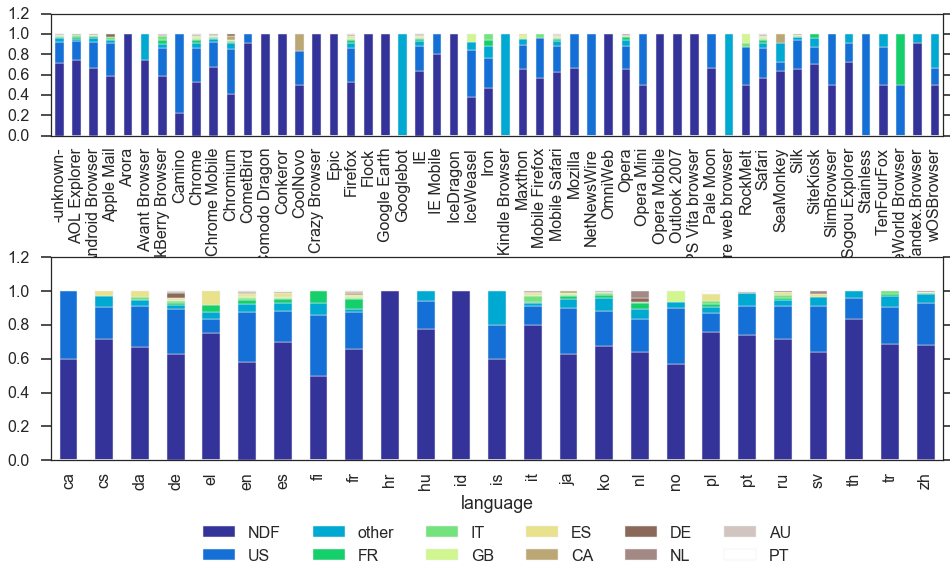

In [294]:
bar_order = ['NDF','US','other','FR','IT','GB','ES','CA','DE','NL','AU','PT']
cat_vars = ['gender', 'signup_method', 'signup_flow', 'affiliate_channel', 'affiliate_provider', 
            'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser', 'language']

from matplotlib.colors import Colormap
fig, ax4 = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
def pltCatVar(var,axis,ax_num):
    ctab = pd.crosstab([df_train[var]], df_train.country_destination).apply(lambda x: x/x.sum(), axis=1)
    ctab[bar_order].plot(kind='bar', stacked=True, ax=axis.reshape(-1)[ax_num],legend=False, 
                         colormap='terrain')

for i,var in enumerate(cat_vars[:8]):
    pltCatVar(var,ax4,i)
plt.tight_layout()
fig, ax5 = plt.subplots(nrows=2, ncols=1, figsize=(16, 8), sharey=True)

for i,var in enumerate(cat_vars[8:]):
    pltCatVar(var,ax5,i)
box = ax5[0].get_position()
ax5[0].set_position([box.x0, box.y0 + box.height * 0.4, box.width, box.height * 0.6])
ax5[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=6)

In [126]:
users['signup_flow'] = users['signup_flow'].astype(str)
signfup_flow_counts = users.signup_flow.value_counts()
users['sigup_flow_gr'] = users.signup_flow.map(lambda x: x if x in signfup_flow_counts.index[:11] else 'other')

In [128]:
users['sigup_flow_gr'].value_counts()

0        206092
25        29834
12        11244
3          8822
2          6881
23         6408
24         4328
1          1047
8           315
6           301
21          197
other        78
Name: sigup_flow_gr, dtype: int64

In [135]:
users['signup_method'].value_counts()
# all users with sign up method weibo are in test set

basic       198222
facebook     74864
google        2438
weibo           23
Name: signup_method, dtype: int64

In [143]:
aff_provider_counts = users.affiliate_provider.value_counts()
users['aff_provider_gr'] = users.affiliate_provider.map(lambda x: x if x in aff_provider_counts.index[:13] else 'other')

In [144]:
users['aff_provider_gr'].value_counts()

direct                 181270
google                  65956
other                   13163
facebook                 3996
bing                     3719
craigslist               3475
padmapper                 836
vast                      830
yahoo                     653
facebook-open-graph       566
gsp                       455
meetup                    358
email-marketing           270
Name: aff_provider_gr, dtype: int64

In [146]:
users.first_affiliate_tracked.value_counts()

untracked        143181
linked            62064
omg               54859
tracked-other      6655
product            2353
marketing           281
local ops            69
Name: first_affiliate_tracked, dtype: int64